In [1]:
import warnings

warnings.filterwarnings('ignore')

import os
import random
import optuna
import numpy as np
import pandas as pd
from tab_transformer_pytorch import FTTransformer
import scipy.stats as st
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler, OneHotEncoder
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything()   

In [3]:
df = pd.read_csv('./impute_set/imp3.csv')

class CustomDataset(Dataset):
    def __init__(self, x, y, cat_col, numeric_col):
        self.X_cat = np.array(x[cat_col]).astype(np.int32)
        self.X_num = np.array(x[numeric_col]).astype(np.float32)
        self.y = np.array(y).astype(np.float32)
        
    def __len__(self):
        return len(self.X_cat)
    
    def __getitem__(self, idx):
        X_cat = torch.from_numpy(self.X_cat[idx])
        X_num = torch.from_numpy(self.X_num[idx])
        y = torch.from_numpy(self.y[idx])
        return X_cat, X_num, y
    


def preprocessing(df, numeric='minmax', category='label'):
    X = df.drop('BS3_1', axis=1)
    y = df[['BS3_1']]
    numeric_col = [
        'FEV1', 'FEV1FVC', 'age', 'BS6_3', 'BS6_2_1', 'BD1',
        '건강문해력', 'Total_slp_wk', 'EQ_5D', 'BE3_31', 'BE5_1', '질환유병기간'
    ]
    cat_col = []
    for col in X.columns:
        if col not in numeric_col:
            cat_col.append(col)

    df_num, df_cat = X[numeric_col], X[cat_col]
    if numeric == 'minmax':
        n_pre = MinMaxScaler()
    else:
        n_pre = StandardScaler()
    df_num = pd.DataFrame(n_pre.fit_transform(df_num), columns=df_num.columns)

    if category == 'label':
        c_pre = OrdinalEncoder()
        df_cat = pd.DataFrame(c_pre.fit_transform(df_cat), columns=df_cat.columns)
    else:
        c_pre = OneHotEncoder(sparse_output=False)
        df_cat = pd.DataFrame(c_pre.fit_transform(df_cat))

    X = pd.concat([df_num, df_cat], axis=1)
    uniques = []
    for col in cat_col:
        uniques.append(len(X[col].unique()))

    return X, y, uniques, numeric_col, cat_col    

def test_with_imputations(model, train_loader, test_loader, test_y):

    # class_counts = torch.tensor([test_y.value_counts()[0], test_y.value_counts()[1]])
    # class_weights = 1.0 / class_counts
    # class_weights /= class_weights.sum()

    # device = torch.device('cuda')
    # # model = FTTransformer(
    # #     categories=tuple(uniques),
    # #     num_continuous=len(numeric_col),
    # #     dim=64,dim_out=1,depth=6,heads=8,attn_dropout=.2,ff_dropout=.2
    # # )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_negatives = (test_y == 0).sum()
    num_positives = (test_y == 1).sum()
    class_weights = torch.tensor(num_negatives / num_positives, dtype=torch.float32).to(device)    

    model = model.to(device)
    optim = Adam(model.parameters(), lr=.0001)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    best_f1 = 0.0
    best_epoch = 0
    epochs = 200
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for x_cat, x_num, yy in train_loader:
            optim.zero_grad()
            x_cat, x_num, yy = x_cat.to(device), x_num.to(device), yy.to(device)
            preds = model(x_cat, x_num)
            loss = criterion(preds.squeeze(), yy.squeeze())
            loss.backward()
            optim.step()
            running_loss += loss.item()
        # print(f'{epoch+1} Epoch | Loss: {running_loss/len(train_loader):.4f}')

        model.eval()
        val_loss = 0.0
        correct = 0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for x_cat, x_num, yy in test_loader:
                x_cat, x_num, yy = x_cat.to(device), x_num.to(device), yy.to(device)
                preds = model(x_cat, x_num)
                val_loss += criterion(preds.squeeze(), yy.squeeze()).item()
                yy = yy.detach().cpu().numpy().squeeze()
                preds = torch.sigmoid(preds).detach().cpu().numpy().squeeze()
                pred_labels = np.where(preds>=.5, 1, 0)
                correct += (pred_labels == yy).sum().item()
                
                val_preds.extend(pred_labels.tolist())
                val_targets.extend(yy.tolist())
        val_loss /= len(test_loader)
        val_f1 = f1_score(val_targets, val_preds, average='macro')
        # print(f'{epoch+1} Epoch | TestLoss: {val_loss:.4f} | TestF1: {val_f1:.4f}')
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch+1
            torch.save(model.state_dict(), 'bestFTTransformer.pth')
            
    print(f'Best Epoch: {best_epoch} | Best F1 : {best_f1:.4f}')  
    return best_f1


def test_with_5fold(df, numeric, category, shuffle=True):
    f1s = []
    X, y, uniques, numeric_col, cat_col = preprocessing(df, numeric, category)
    if shuffle:
        skf = StratifiedKFold(n_splits=5, shuffle=shuffle, random_state=42)
    else:
        skf = StratifiedKFold(n_splits=5, shuffle=shuffle)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        train_X, train_y = X.iloc[train_idx], y.iloc[train_idx]
        test_X, test_y = X.iloc[test_idx], y.iloc[test_idx]

        train_set = CustomDataset(train_X, train_y, cat_col, numeric_col)
        test_set = CustomDataset(test_X, test_y, cat_col, numeric_col)
        train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True)
        test_loader = DataLoader(test_set, batch_size=64, shuffle=True, pin_memory=True)

        f1_value = test_with_imputations(
            train_loader, test_loader, test_y, uniques, numeric_col
        )
        f1s.append(f1_value)

    return f1s


def get_cv_results(f1s:list):
    f1s = np.array(f1s)
    mean_f1 = np.mean(f1s)
    std_f1 = np.std(f1s)
    ci95 = st.t.interval(.95, df=len(f1s)-1, loc=mean_f1, scale=std_f1/np.sqrt(len(f1s)))
    return mean_f1, std_f1, ci95

In [4]:
# for final(shap)
def forfinal(df):
    from sklearn.model_selection import train_test_split
    f1s = []
    X, y, uniques, numeric_col, cat_col = preprocessing(df, "standard", "label")    
    train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=42, test_size=.2, stratify=y)
    class_counts = torch.tensor([train_y.value_counts()[0], train_y.value_counts()[1]])

    train_set = CustomDataset(train_X, train_y, cat_col, numeric_col)
    test_set = CustomDataset(test_X, test_y, cat_col, numeric_col)
    g = torch.Generator()
    g.manual_seed(42)
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True, pin_memory=True, generator=g)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False, pin_memory=True, generator=g)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_negatives = (test_y == 0).sum()
    num_positives = (test_y == 1).sum()
    class_weights = torch.tensor(num_negatives / num_positives, dtype=torch.float32).to(device)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = FTTransformer(
        categories=tuple(uniques),
        num_continuous=len(numeric_col),
        dim=89,dim_out=1,depth=3,heads=8,attn_dropout=0.40935237527898183,ff_dropout=0.40935237527898183
    )
    model = model.to(device)
    optim = Adam(model.parameters(), lr=.0001)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1].to(device))
    best_f1 = 0.0
    best_epoch = 0
    epochs = 500
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x_cat, x_num, yy in train_loader:
            x_cat, x_num, yy = x_cat.to(device), x_num.to(device), yy.to(device)
            optim.zero_grad()
            preds = model(x_cat, x_num)
            loss = criterion(preds.squeeze(), yy.squeeze())
            loss.backward()
            optim.step()
            running_loss += loss.item()
        model.eval()
        test_loss = 0.0
        corr = 0
        test_preds = []
        test_targets = []
        with torch.no_grad():
            for x_cat, x_num, yy in test_loader:
                x_cat, x_num, yy = x_cat.to(device), x_num.to(device), yy.to(device)
                preds = model(x_cat, x_num)
                test_loss += criterion(preds.squeeze(), yy.squeeze()).item()
                yy = yy.detach().cpu().numpy().squeeze()
                # preds = preds.detach().cpu().numpy().squeeze()
                
                preds = torch.sigmoid(preds).detach().cpu().numpy().squeeze()
                pred_labels = np.where(preds>=.5, 1, 0)

                corr += (pred_labels == yy).sum().item()
                
                test_preds.extend(pred_labels.tolist())
                test_targets.extend(yy.tolist())
            test_loss /= len(test_loader)
            test_f1 = f1_score(test_targets, test_preds, average='macro')
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_epoch = epoch+1
            torch.save(model.state_dict(), 'bestFT.pth')
    print(f'Best Epoch: {best_epoch} | Best F1 : {best_f1:.4f}')
    return model, test_set, test_loader

In [5]:
model, test_set, test_loader = forfinal(df)

Best Epoch: 22 | Best F1 : 0.7659


In [6]:
model.load_state_dict(torch.load('./bestFT.pth'))

<All keys matched successfully>

In [7]:
import shap
dd_cat = test_set.X_cat
dd_num = test_set.X_num
def model_func(data):
    data = torch.from_numpy(data)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x_cat, x_num = data[:, :dd_cat.shape[1]].to(device).int(), data[:, dd_cat.shape[1]:].to(device).float()
    return model(x_cat, x_num).detach().cpu().numpy()
    

data = np.concatenate((dd_cat, dd_num), axis=1)
explainer = shap.Explainer(model_func, data)

In [8]:
shap_values = explainer.shap_values(data)

PermutationExplainer explainer: 71it [1:10:54, 61.66s/it]                         


In [9]:
X = df.drop('BS3_1', axis=1)
y = df[['BS3_1']]
numeric_col = [
        'FEV1', 'FEV1FVC', 'age', 'BS6_3', 'BS6_2_1', 'BD1',
        '건강문해력', 'Total_slp_wk', 'EQ_5D', 'BE3_31', 'BE5_1', '질환유병기간'
]
cat_col = []
for col in X.columns:
    if col not in numeric_col:
        cat_col.append(col)

In [10]:
cols = cat_col + numeric_col
col_dict={
 # categorical (HE_DM | DE1_dg: 당뇨병 의사진단 여부 --> 당뇨병 유병률(Diabetes prevalence))
 'sex':'Sex', 'occp':'Occupation', 'Edu':'Education level', 'EC1_1':'EEA', '금연지지가족친구여부':'FFSQ', 
 'marri_1':'Marital status', '손자손녀동거여부':'LWG', '건강문해력':'PHS', 'HE_PFThs':'CRH', 'HE_cough1':'CL3M',
 'HE_sput1':'SP3M', '가래양상':'Sputum characteristics', 'BH9_11':'Influenza vaccination', 'DI1_dg':'PDG', 
 'DE1_dg':'Diabetes prevalence', 'DC6_dg':'PDLC', 'BP1':'PSL', 'BP5':'DS2W', 'D_1_1':'Health literacy', 'BS5_1':'PQS-1M', 
 '자기효능감':'Self-efficacy', 'N_DUSUAL':'CUFI', 'BE3_31':'WDW', 'BE5_1':'STDW', 'LQ4_05':'Activity limitation', 
 'BH1_1':'Health check-up', 'BO2_1':'BWCY', 'BO1_1':'BWChY', '질환유병기간':'COPD duration', 'DI1_pt':'Hypertension treatment',
 'DI1_2':'AMU', 'DE1_pt':'Diabetes treatment', 'DE1_3':'DMU', '심한금단증상경험여부':'SWS-E', '전문가의금연권유':'PAQ',
 # numeric
#  'FEV1':'FEV1', 'HE_fev1fvc':'FEV1/FVC', 'age':'Age', 'BS6_3':'Smoking amount',
 'FEV1':'FEV1', 'FEV1FVC':'FEV1/FVC', 'age':'Age', 'BS6_3':'Smoking amount',
 'BS6_2_1':'Smoking duration', 'BD1':'Alcohol consumption', 'Total_slp_wk':'AST', 'EQ_5D':'QoL'
}

feature_names=[col_dict[fcol] for fcol in cols]

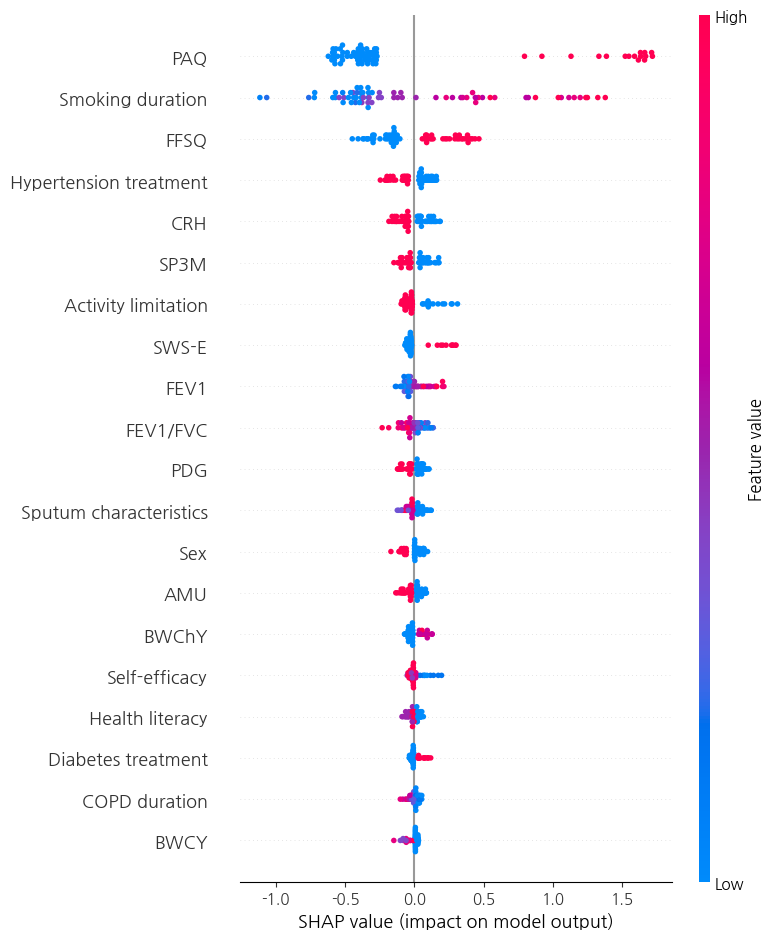

In [ ]:
# label (0: 비흡연 | 1: 흡연)
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.suptitle('Shap Values (FT-Transformer)')
shap.summary_plot(shap_values, data, feature_names=feature_names)